In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [3]:
###mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the stock price data

In [4]:
stock_df= pd.read_csv('./drive/My Drive/Colab Notebooks/GME_stock.csv',parse_dates=["date"])

In [5]:
stock_df.tail()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666


In [6]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
0,2021-01-28,265.000000,483.000000,112.250000,193.600006,58815800.0,193.600006
1,2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010
2,2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996
3,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
4,2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002


The data has inverted order by date. We need to change it in  date ascending order.

In [7]:
stock_df=stock_df.sort_values(by="date", ascending=True)
stock_df.reset_index(inplace=True)
stock_df.set_index('date',inplace=True)

In [8]:
stock_df.head()

,index,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,,
2002-02-13,4772,9.625,10.060,9.525,10.050,19054000.0,6.766666
2002-02-14,4771,10.175,10.195,9.925,10.000,2755400.0,6.733003
2002-02-15,4770,10.000,10.025,9.850,9.950,2097400.0,6.699336
2002-02-19,4769,9.900,9.900,9.375,9.550,1852600.0,6.430017
2002-02-20,4768,9.600,9.875,9.525,9.875,1723200.0,6.648838


Build BPNN model


In [9]:
def convert2matrix(data_arr, look_back):
 X, Y =[], []
 for i in range(len(data_arr)-look_back):
  d=i+look_back  
  X.append(data_arr[i:d,0])
  Y.append(data_arr[d,0])
 return np.array(X), np.array(Y)

In [10]:
df = stock_df['close_price']  ### just take close price information for model training

In [11]:
arr_data = np.array(df).reshape(-1,1) # reshape it to the array

In [12]:
X,Y= convert2matrix(arr_data, 30) ##callback 30 previous days' close price data.

In [13]:
stock_price_new_df=pd.concat([pd.DataFrame(X),pd.DataFrame(Y)],axis=1)

In [14]:
stock_price_new_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,0
0,10.050,10.000,9.950,9.550,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.65,9.860,9.990,10.300,10.100
1,10.000,9.950,9.550,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.650,9.86,9.990,10.300,10.100,9.525
2,9.950,9.550,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.650,9.860,9.99,10.300,10.100,9.525,9.320
3,9.550,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.650,9.860,9.990,10.30,10.100,9.525,9.320,9.300
4,9.875,9.850,9.675,9.750,9.750,9.575,9.550,9.685,9.850,9.625,9.675,10.210,10.450,10.585,10.600,10.510,10.500,10.175,9.650,9.350,9.010,9.375,9.650,9.860,9.990,10.300,10.10,9.525,9.320,9.300,9.475


In [15]:
stock_price_new_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,0
4738,16.940001,13.66,14.12,13.31,12.72,13.85,13.850000,14.830000,15.630000,15.530000,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002
4739,13.660000,14.12,13.31,12.72,13.85,13.85,14.830000,15.630000,15.530000,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002,76.790001
4740,14.120000,13.31,12.72,13.85,13.85,14.83,15.630000,15.530000,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002,76.790001,147.979996
4741,13.310000,12.72,13.85,13.85,14.83,15.63,15.530000,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002,76.790001,147.979996,347.510010
4742,12.720000,13.85,13.85,14.83,15.63,15.53,19.459999,20.570000,20.150000,20.990000,19.379999,19.260000,18.840000,17.250000,17.370001,18.360001,18.080000,17.690001,19.940001,19.950001,31.400000,39.910000,35.500000,39.360001,39.119999,43.029999,65.010002,76.790001,147.979996,347.510010,193.600006


In [16]:
stock_price_new_df.shape

(4743, 31)

In [17]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [18]:
Y=Y.reshape(-1,1)

In [19]:
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

In [20]:
train_size=ceil(X.shape[0]*0.8)
trainX,testX=X_scaled[0:train_size],X_scaled[train_size:]
trainY,testY=Y_scaled[0:train_size],Y_scaled[train_size:]
# train_size=ceil(X.shape[0]*0.8)
# trainX,testX=X[0:train_size],X[train_size:]
# trainY,testY=Y[0:train_size],Y[train_size:]

In [21]:
trainX.shape , trainY.shape

((3795, 30), (3795, 1))

In [22]:
testX.shape, testY.shape

((948, 30), (948, 1))

Below extract the date information in training and test dataset:

In [23]:
dates_training = pd.to_datetime(stock_df.index[:train_size])
dates_test = pd.to_datetime(stock_df.index[train_size:-30])

In [24]:
from keras.models import Sequential
from keras.layers import Dense
def model_dnn(look_back):
  model=Sequential()
  model.add(Dense(units=64,input_dim=look_back,activation='relu'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse','mae'])
  return model

In [25]:
model=model_dnn(30)
model.summary()
history=model.fit(trainX,trainY,
                  epochs=100,
                  batch_size=32,
                  verbose=1,
                  validation_data=(testX,testY),
                  shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,041
Trainable params: 3,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 0.2841 - mse: 0.2841 - mae: 0.3875 - val_loss: 0.7179 - val_mse: 0.7179 - val_mae: 0.2437
Epoch 2/100
119/119 [==============================] - 0s 2ms/step - loss: 0.0247 - mse: 0.0247 - mae: 0.1169 - val_loss: 0.6448 - val_mse: 0.6448 - val_mae: 0.1345
Epoch 3/100
119/119 [==============================] -

In [26]:
def model_loss(history):
  plt.figure(figsize=(8,4))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Test Loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(loc='upper right')
  plt.show()

Train Root Mean Squared Error(RMSE): 0.10; Train Mean Absolute Error(MAE) : 0.07 
Test Root Mean Squared Error(RMSE): 0.59; Test Mean Absolute Error(MAE) : 0.12 


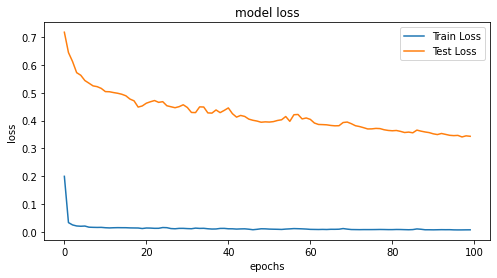

In [27]:
train_score = model.evaluate(trainX,trainY, verbose=0)  
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))  ###这里用了np.sqrt()
test_score = model.evaluate(testX,testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [28]:
def prediction_plot(testY,test_predict):
  len_prediction=[x for x in range(len(testY))]
  plt.figure(figsize=(8,4))
  plt.plot(len_prediction[-200:],testY[-200:],marker='.',label='actual')
  plt.plot(len_prediction[-200:], test_predict[-200:],'r',label='prediction')
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.ylabel('stock_price',size=15)
  plt.xlabel('Time step',size=15)
  plt.legend(fontsize=15)
  plt.title('Prediction VS Actual Stock Price after 30 days_Test data')
  plt.show()

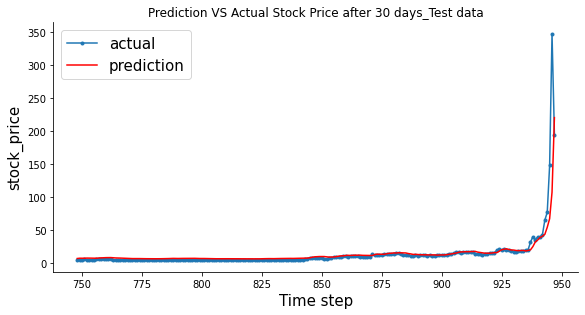

In [29]:
test_predict=model.predict(testX)
testY_predict_value=scaler_Y.inverse_transform(test_predict)
testY_actual_value=scaler_Y.inverse_transform(testY)
prediction_plot(testY_actual_value,testY_predict_value)


In [30]:
testY_actual_value[0]

array([23.39999962])

In [31]:
Y[3795]

array([23.39999962])

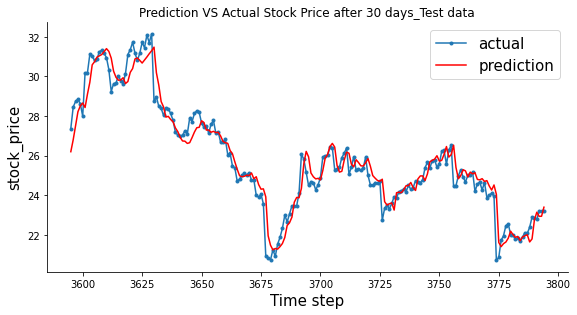

In [32]:
train_predict=model.predict(trainX)
trainY_predict_value=scaler_Y.inverse_transform(train_predict)
trainY_actual_value=scaler_Y.inverse_transform(trainY)
prediction_plot(trainY_actual_value,trainY_predict_value)


In [33]:
from sklearn.metrics import r2_score
R_2 = r2_score(testY_actual_value,testY_predict_value)
R_2

0.6716550538689974

In [34]:
testY= np.array(testY).reshape(-1,1)
y_var_test=testY[1:]-testY[:len(testY)-1]
y_var_predict=test_predict[1:]-test_predict[:len(test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('Accuracy of price changing direction:',result)


Accuracy of price changing direction: 0.4931362196409715
